<a href="https://colab.research.google.com/github/linukc/robocup/blob/master/model_training_and_h52pb2onnx_convertion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing libraries

In [ ]:
!pip uninstall -y tensorflow, albumentations

In [ ]:
!pip install albumentations, tensorflow-gpu==1.15.3, segmentation-models

# Importing libraries, Setuping some important variables and attributiones

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import segmentation_models as sm
sm.set_framework('tf.keras')
import albumentations as A

# sm.Unet learning -> .h5

In [ ]:
DATA_DIR = '/content/drive/My Drive/data'
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [ ]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['beam', 'shaft', 'sleeve', 'square', 'kremlin', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[self.indexes[j]])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
dataset = Dataset(x_test_dir, y_test_dir, classes=['beam', 'shaft', 'sleeve', 'square', 'kremlin'])

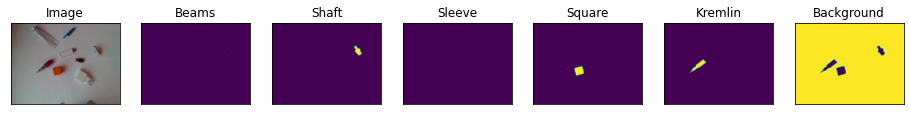

In [ ]:
image, mask = dataset[0]
visualize(
    image=image, 
    beams=mask[..., 0].squeeze(),
    shaft=mask[..., 1].squeeze(),
    sleeve=mask[..., 2].squeeze(),
    square=mask[..., 3].squeeze(),
    kremlin=mask[..., 4].squeeze(),
    background=mask[..., 5].squeeze()
)

In [ ]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    #-padding
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

      

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


# def get_validation_augmentation():
#     """Add paddings to make image shape divisible by 32"""
#     test_transform = [
#         A.PadIfNeeded(384, 480)
#     ]
#     return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [ ]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 4
CLASSES = ['beam', 'shaft', 'sleeve', 'square', 'kremlin']
LR = 0.0001
EPOCHS = 80

preprocess_input = sm.get_preprocessing(BACKBONE)

n_classes = 6
activation = 'softmax'

model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, input_shape=(480, 640, 3))

In [ ]:
# define optomizer
optim = tf.keras.optimizers.Adam(LR)
total_loss = sm.losses.binary_focal_dice_loss
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model.compile(optim, total_loss, metrics)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)


# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/data/model4_checkpoint.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/80
7/7 [==============================] - 305s 44s/step - loss: 1.0489 - iou_score: 0.0102 - f1-score: 0.0198 - val_loss: 1.2694 - val_iou_score: 0.0037 - val_f1-score: 0.0067
Epoch 2/80
7/7 [==============================] - 7s 946ms/step - loss: 1.0313 - iou_score: 0.0226 - f1-score: 0.0418 - val_loss: 1.3160 - val_iou_score: 0.0046 - val_f1-score: 0.0083
Epoch 3/80
7/7 [==============================] - 7s 969ms/step - loss: 1.0168 - iou_score: 0.0232 - f1-score: 0.0423 - val_loss: 1.3470 - val_iou_score: 0.0065 - val_f1-score: 0.0110
Epoch 4/80
7/7 [==============================] - 7s 979ms/step - loss: 1.0031 - iou_score: 0.0375 - f1-score: 0.0665 - val_loss: 1.4811 - val_iou_score: 0.0129 - val_f1-score: 0.0182
Epoch 5/80
7/7 [==============================] - 7s 980ms/step - loss: 0.9861 - iou_score: 0.0455 - f1-score: 0.0785 - val_loss: 1.5918 - val_iou_score: 0.0108 - val_f1-score: 0.0161
Epoch 6/80
7/7 [==============================] - 7s 957ms/step - loss: 0.9722 -

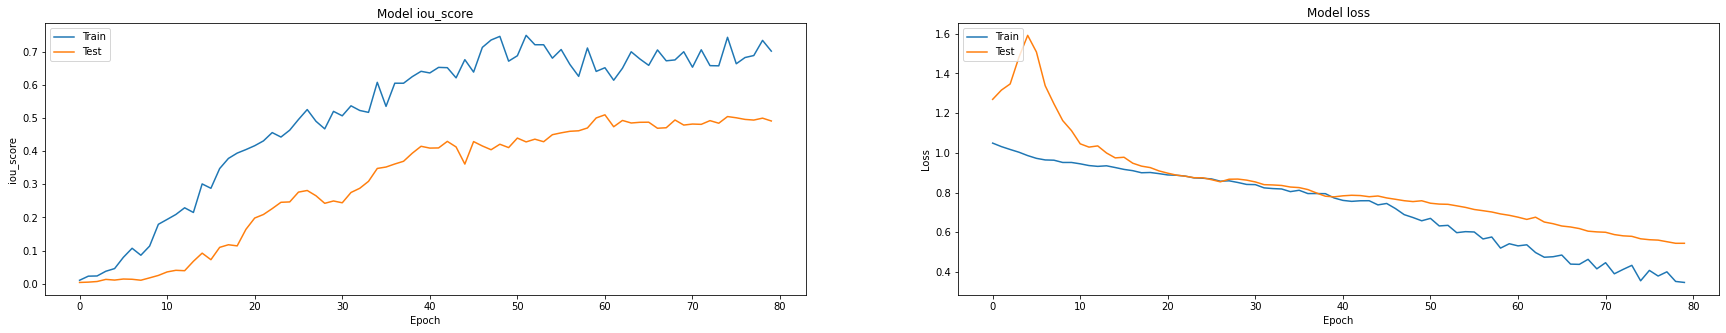

In [ ]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('/content/drive/My Drive/data/modelv4_checkpoint.h5')

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.44861
mean iou_score: 0.66473
mean f1-score: 0.6962


(480, 640, 6)


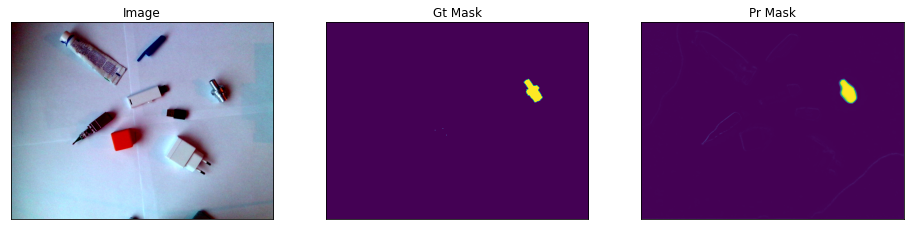

(480, 640, 6)


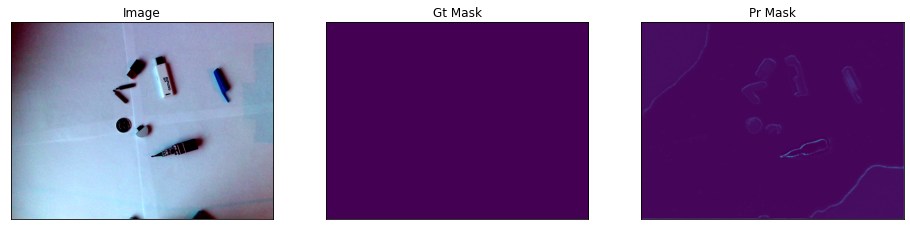

(480, 640, 6)


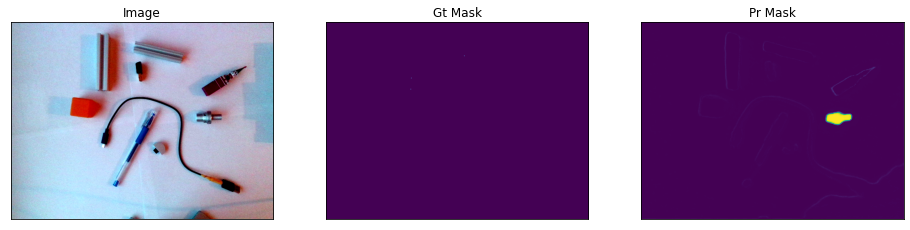

(480, 640, 6)


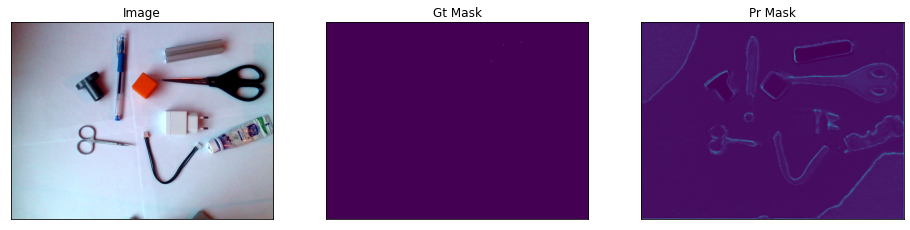

(480, 640, 6)


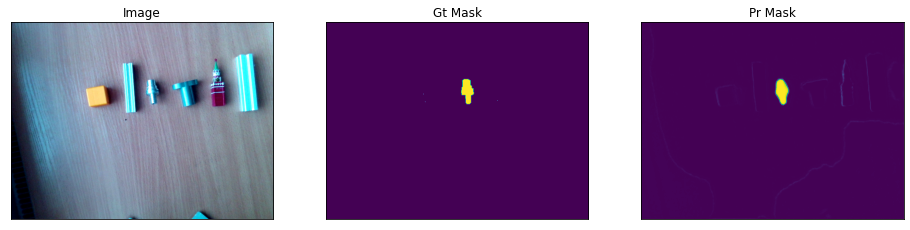

In [ ]:
for i in range(len(test_dataset)):
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask_beam=gt_mask[..., 0].squeeze(),
        pr_mask_beam=pr_mask[..., 0].squeeze(),
        gt_mask_shaft=gt_mask[..., 1].squeeze(),
        pr_mask_shaft=pr_mask[..., 1].squeeze(),
        gt_mask_sleeve=gt_mask[..., 2].squeeze(),
        pr_mask_sleeve=pr_mask[..., 2].squeeze(),
        gt_mask_square=gt_mask[..., 3].squeeze(),
        pr_mask_square=pr_mask[..., 3].squeeze(),
        gt_mask_kremlin=gt_mask[..., 4].squeeze(),
        pr_mask_kremlin=pr_mask[..., 4].squeeze(),

    )

In [ ]:
model.save('/content/drive/My Drive/data/modelv4.h5')

# Converting .h5 -> .pb

In [ ]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.optimizers import Optimizer
from tensorflow.keras.models import load_model
from tensorflow import nn
from tensorflow.keras.backend import shape
from tensorflow.keras.layers import Dropout

def config_keras_backend():
    """Config tensorflow backend to use less GPU memory."""
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    tf.keras.backend.set_session(session)


def clear_keras_session():
    """Clear keras session.
    This is for avoiding the problem of: 'Exception ignored in: <bound method BaseSession.__del__ of <tensorflow.python.client.session.Session object ...'
    """
    tf.keras.backend.clear_session()

class AdamW(Optimizer):
    """AdamW optimizer.
    Default parameters follow those provided in the original paper.
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: float >= 0. Decoupled weight decay over each update.
        weight_decay_normalizer: float >= 0. Calculated as: 1. / sqrt(batches_per_epoch * num_epochs)
    # References
        - [Adam - A Method for Stochastic Optimization](http://arxiv.org/abs/1412.6980v8)
        - [Optimization for Deep Learning Highlights in 2017](http://ruder.io/deep-learning-optimization-2017/index.html)
        - [Fixing Weight Decay Regularization in Adam](https://arxiv.org/abs/1711.05101)
    """

    def __init__(self,
                 lr=0.001,
                 beta_1=0.9,
                 beta_2=0.999,
                 epsilon=None,
                 decay=0.,
                 weight_decay=0.0025,         # decoupled weight decay (1/6)
                 weight_decay_normalizer=1.,  #
                 **kwargs):
        super(AdamW, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.init_lr = lr  # decoupled weight decay (2/6)
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.wd = K.variable(weight_decay, name='weight_decay')  # decoupled weight decay (3/6)
            self.wd_normalizer = weight_decay_normalizer             #
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]
        wd = self.wd * self.wd_normalizer  # decoupled weight decay (4/6)

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. /
                       (1. + self.decay *
                             math_ops.cast(self.iterations,
                                          K.dtype(self.decay))))
        eta_t = lr / self.init_lr    # decoupled weight decay (5/6)

        with ops.control_dependencies([state_ops.assign_add(self.iterations, 1)]):
            t = math_ops.cast(self.iterations, K.floatx())
        """Bias corrections according to the Adam paper."""
        lr_t = lr * (K.sqrt(1. - math_ops.pow(self.beta_2, t)) /
                     (1. - math_ops.pow(self.beta_1, t)))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        self.weights = [self.iterations] + ms + vs

        for p, g, m, v in zip(params, grads, ms, vs):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * math_ops.square(g)
            p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)
            p_t -= eta_t * wd * p  # decoupled weight decay (6/6)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'weight_decay': float(K.get_value(self.wd)),
                  'epsilon': self.epsilon}
        base_config = super(AdamW, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    class FixedDropout(Dropout):
        def _get_noise_shape(self, inputs):
            if self.noise_shape is None:
                return self.noise_shape
            return tuple([shape(inputs)[i] if sh is None else sh for i, sh in enumerate(self.noise_shape)])
    
    def keras_to_pb(model, output_filename, output_node_names):
    """
    This is the function to convert the Keras model to pb.
    Args:
       model: The Keras model.
       output_filename: The output .pb file name.
       output_node_names: The output nodes of the network. If None, then
           the function gets the last layer name as the output node.
    """

    # Get the names of the input and output nodes.
    in_name = model.layers[0].get_output_at(0).name.split(':')[0]

    if output_node_names is None:
        output_node_names = [model.layers[-1].get_output_at(0).name.split(':')[0]]

    sess = tf.keras.backend.get_session()

    # The TensorFlow freeze_graph expects a comma-separated string of
    # output node names.
    output_node_names_tf = ','.join(output_node_names)

    frozen_graph_def = tf.graph_util.convert_variables_to_constants(
       sess,
       sess.graph_def,
       output_node_names)

    wkdir = ''
    tf.train.write_graph(
         frozen_graph_def, wkdir, output_filename, as_text=False)

    return in_name, output_node_names

In [ ]:
def main():
    h5 = '/content/drive/My Drive/data/model_v4.h5'
    pb = '/content/drive/My Drive/data/model_v4_pb.pb'

    config_keras_backend()
    tf.keras.backend.set_learning_phase(0)

    model = tf.keras.models.load_model(
    h5, compile=False, custom_objects={'AdamW': AdamW, 'swish': nn.swish, 'FixedDropout': FixedDropout})

    in_tensor_name, out_tensor_names = keras_to_pb(model, pb, None)
    print('input tensor: ', in_tensor_name)
    print('output tensors: ', out_tensor_names)

    clear_keras_session()

In [ ]:
main()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 546 variables.
INFO:tensorflow:Converted 546 variables to const ops.
input tensor:  input_4_1
output tensors:  ['softmax_4/truediv']


# Converting .pb -> .onnx

In [ ]:
!pip3 install  tf2onnx

     |████████████████████████████████| 194kB 8.1MB/s 
     |████████████████████████████████| 7.4MB 14.5MB/s 


In [ ]:
!python3 -m tf2onnx.convert --input '/content/drive/My Drive/data/model_v4_pb.pb' --inputs input_4_1:0 --outputs softmax_4/truediv:0 --output '/content/drive/My Drive/data/model_v4_onnx.onnx' --opset 11


2020-09-27 20:19:09,916 - WARNING - From /usr/local/lib/python3.6/dist-packages/tf2onnx/verbose_logging.py:76: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

2020-09-27 20:19:12,320 - INFO - Using tensorflow=1.15.3, onnx=1.7.0, tf2onnx=1.6.3/d4abc8
2020-09-27 20:19:12,320 - INFO - Using opset <onnx, 11>
2020-09-27 20:19:22,701 - INFO - Optimizing ONNX model
2020-09-27 20:19:57,467 - INFO - After optimization: BatchNormalization -81 (88->7), Const -563 (893->330), Gather +6 (0->6), Identity -20 (20->0), Reshape +1 (52->53), Shape -4 (36->32), Squeeze -26 (26->0), Transpose -465 (494->29), Unsqueeze -104 (104->0)
2020-09-27 20:19:57,521 - INFO - 
2020-09-27 20:19:57,521 - INFO - Successfully converted TensorFlow model /content/drive/My Drive/data/model_v4_pb.pb to ONNX
2020-09-27 20:19:57,756 - INFO - ONNX model is saved at /content/drive/My Drive/data/model_v4_onnx.onnx


# Extra tool - sm.Unet keras model straight to .onnx

In [ ]:
!pip install keras2onnx
from keras2onnx import convert_keras
tf.keras.backend.clear_session()

onnx_path = '/content/drive/My Drive/data/unet.onnx'

model._layers[0].batch_input_shape = (1, 480, 640, 3)
model = keras.models.clone_model(model)

onx = convert_keras(model, onnx_path)
with open(onnx_path, "wb") as f:
  f.write(onx.SerializeToString())

# OpenCV contours

In [ ]:
#Add cv2.GauseBlur
a = np.where(a < 225, 0, a)
a = np.where(a > 225, 255, a)

In [ ]:
contours, hierarchy  = cv2.findContours(a, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

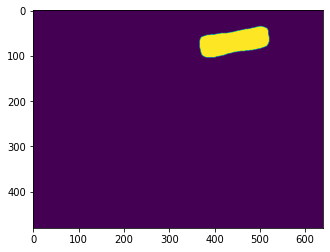

In [ ]:
cv2.drawContours( a, contours, -1, (255,0,0), 3, cv2.LINE_AA, hierarchy, 1 )
plt.imshow(a)
plt.show()